Make sure DMBA package is installed

In [1]:
pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 38.1 MB/s eta 0:00:00


In [2]:
from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

import dmba

%matplotlib inline


Colab environment detected.


In [3]:
utilities_df = dmba.load_data('Utilities.csv')
utilities_df.set_index('Company', inplace=True)

# while not required, the conversion of integer data to float will avoid a warning when
# applying the scale function
utilities_df = utilities_df.apply(lambda x: x.astype('float64'))
utilities_df.head()

,Fixed_charge,RoR,Cost,Load_factor,Demand_growth,Sales,Nuclear,Fuel_Cost
Company,,,,,,,,
Arizona,1.06,9.2,151.0,54.4,1.6,9077.0,0.0,0.628
Boston,0.89,10.3,202.0,57.9,2.2,5088.0,25.3,1.555
Central,1.43,15.4,113.0,53.0,3.4,9212.0,0.0,1.058
Commonwealth,1.02,11.2,168.0,56.0,0.3,6423.0,34.3,0.700
NY,1.49,8.8,192.0,51.2,1.0,3300.0,15.6,2.044


Compute Euclidean distance matrix (to compute other metrics, change the name of `metric` argument)

In [4]:
d = pairwise.pairwise_distances(utilities_df, metric='euclidean')
pd.DataFrame(d, columns=utilities_df.index, index=utilities_df.index).head(5)

Company,Arizona,Boston,Central,Commonwealth,NY,Florida,Hawaiian,Idaho,Kentucky,Madison,...,Northern,Oklahoma,Pacific,Puget,San Diego,Southern,Texas,Wisconsin,United,Virginia
Company,,,,,,,,,,,,,,,,,,,,,
Arizona,0.000000,3989.408076,140.402855,2654.277632,5777.167672,2050.529440,1435.265019,4006.104187,671.276346,2622.699002,...,1899.279821,598.556633,2609.045363,6914.742065,3363.061626,1063.009074,4430.251585,1790.485648,2427.588875,1016.617691
Boston,3989.408076,0.000000,4125.044132,1335.466502,1788.068027,6039.689076,2554.287162,7994.155985,3318.276558,1367.090634,...,2091.160485,4586.302564,1380.749962,10903.146464,629.760748,5052.331669,8419.610541,2199.721665,1562.210811,5005.081262
Central,140.402855,4125.044132,0.000000,2789.759674,5912.552908,1915.155154,1571.295401,3872.257626,807.920792,2758.559663,...,2035.441520,461.341670,2744.502847,6780.430307,3498.113013,928.749249,4295.014690,1925.772564,2563.637362,883.535455
Commonwealth,2654.277632,1335.466502,2789.759674,0.000000,3123.153215,4704.363099,1219.560005,6659.534567,1983.314354,43.648894,...,756.831954,3250.984589,56.644626,9568.434429,710.292965,3717.202963,7084.372839,864.273153,232.476871,3670.018191
NY,5777.167672,1788.068027,5912.552908,3123.153215,0.000000,7827.429211,4342.093798,9782.158178,5106.094153,3155.095594,...,3879.167462,6373.743249,3168.177463,12691.155108,2414.698757,6840.150291,10207.392630,3987.335962,3350.073118,6793.035300



Here are two ways to normalize the input variables. Pandas calculates by default the sample standard deviation, whereas scikit-learn uses the population standard deviation. The normalized data from the two methods will therefore differ slightly. We will use the Pandas approach as it is equivalent to the R implementation of scale.

In [5]:
# scikit-learn uses population standard deviation
utilities_df_norm = utilities_df.apply(preprocessing.scale, axis=0)

# pandas uses sample standard deviation
utilities_df_norm = (utilities_df - utilities_df.mean())/utilities_df.std()

# compute normalized distance based on Sales and Fuel Cost
d_norm = pairwise.pairwise_distances(utilities_df_norm[['Sales', 'Fuel_Cost']],
                                     metric='euclidean')
pd.DataFrame(d_norm, columns=utilities_df.index, index=utilities_df.index).head(5)

Company,Arizona,Boston,Central,Commonwealth,NY,Florida,Hawaiian,Idaho,Kentucky,Madison,...,Northern,Oklahoma,Pacific,Puget,San Diego,Southern,Texas,Wisconsin,United,Virginia
Company,,,,,,,,,,,,,,,,,,,,,
Arizona,1.490116e-08,2.010329,0.774179,0.758738,3.021907,1.244422,1.885248,1.265638,0.461292,0.738650,...,0.564657,0.182648,1.570780,1.947668,2.509043,0.913621,1.247976,0.521491,2.761745,1.252350
Boston,2.010329e+00,0.000000,1.465703,1.582821,1.013370,1.792397,0.740283,3.176654,1.557738,1.719632,...,1.940166,2.166078,0.478334,3.501390,0.679634,1.634425,2.890560,1.654255,1.100595,1.479261
Central,7.741795e-01,1.465703,0.000000,1.015710,2.432528,0.631892,1.156092,1.732777,0.419254,1.102287,...,1.113433,0.855093,0.987772,2.065643,1.836762,0.276440,1.428159,0.838967,2.034824,0.510365
Commonwealth,7.587375e-01,1.582821,1.015710,0.000000,2.571969,1.643857,1.746027,2.003230,0.629994,0.138758,...,0.377004,0.937389,1.258835,2.699060,2.202930,1.278514,1.998818,0.243408,2.547116,1.502093
NY,3.021907e+00,1.013370,2.432528,2.571969,0.000000,2.635573,1.411695,4.162561,2.566439,2.705445,...,2.938637,3.174588,1.462019,4.397433,0.715629,2.558409,3.831132,2.661786,0.952507,2.328691


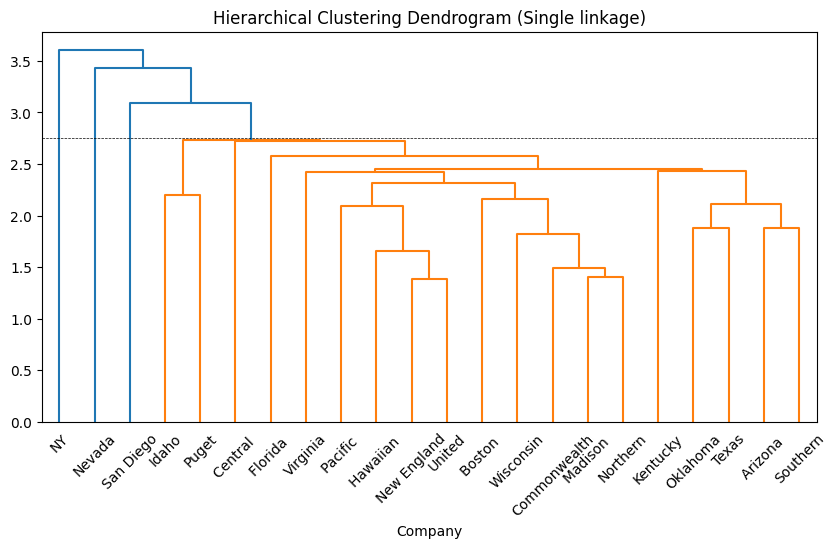

In [6]:
Z = linkage(utilities_df_norm, method='single')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Single linkage)')
plt.xlabel('Company')
dendrogram(Z, labels=utilities_df_norm.index, color_threshold=2.75)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

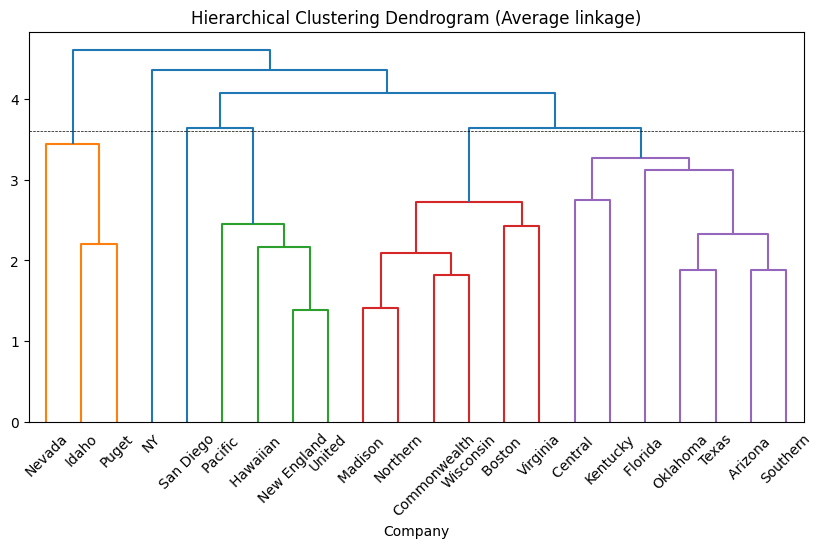

In [7]:
Z = linkage(utilities_df_norm, method='average')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Average linkage)')
plt.xlabel('Company')
dendrogram(Z, labels=utilities_df_norm.index, color_threshold=3.6)
plt.axhline(y=3.6, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [8]:
memb = fcluster(linkage(utilities_df_norm, 'single'), 6, criterion='maxclust')
memb = pd.Series(memb, index=utilities_df_norm.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

1 :  Idaho, Puget
2 :  Arizona , Boston , Commonwealth, Florida , Hawaiian , Kentucky, Madison , New England, Northern, Oklahoma, Pacific , Southern, Texas, Wisconsin, United, Virginia
3 :  Central 
4 :  San Diego
5 :  Nevada
6 :  NY


In [ ]:
memb = fcluster(linkage(utilities_df_norm, 'average'), 6, criterion='maxclust')
memb = pd.Series(memb, index=utilities_df_norm.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

1 :  Idaho, Nevada, Puget
2 :  Hawaiian , New England, Pacific , United
3 :  San Diego
4 :  Boston , Commonwealth, Madison , Northern, Wisconsin, Virginia
5 :  Arizona , Central , Florida , Kentucky, Oklahoma, Southern, Texas
6 :  NY


## K-Means

In [11]:
# Load and preprocess data
#utilities_df = dmba.load_data('Utilities.csv')
#utilities_df.set_index('Company', inplace=True)
#utilities_df = utilities_df.apply(lambda x: x.astype('float64'))

# Normalized distance
#utilities_df_norm = utilities_df.apply(preprocessing.scale, axis=0)

kmeans = KMeans(n_clusters=6, random_state=0).fit(utilities_df_norm)

# Cluster membership
memb = pd.Series(kmeans.labels_, index=utilities_df_norm.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

0 :  Commonwealth, Madison , Northern, Wisconsin, Virginia
1 :  Boston , Hawaiian , New England, Pacific , San Diego, United
2 :  Arizona , Central , Florida , Kentucky, Oklahoma, Southern, Texas
3 :  NY
4 :  Nevada
5 :  Idaho, Puget


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=utilities_df_norm.columns)
pd.set_option('display.precision', 3)
print(centroids)
pd.reset_option('display.precision')

   Fixed_charge    RoR   Cost  Load_factor  Demand_growth  Sales  Nuclear  \
0        -0.012  0.339  0.224       -0.366          0.170 -0.411    1.602   
1        -0.633 -0.640  0.207        1.175          0.058 -0.758   -0.381   
2         0.516  0.798 -1.009       -0.345         -0.501  0.360   -0.536   
3         2.085 -0.883  0.592       -1.325         -0.736 -1.619    0.219   
4        -2.020 -1.476  0.120       -1.257          1.070  2.458   -0.731   
5         0.088 -0.541  1.996       -0.110          0.988  1.621   -0.731   

   Fuel_Cost  
0     -0.609  
1      1.204  
2     -0.420  
3      1.732  
4     -0.616  
5     -1.175  


In [12]:
# calculate the distances of each data point to the cluster centers
distances = kmeans.transform(utilities_df_norm)

# reduce to the minimum squared distance of each data point to the cluster centers
minSquaredDistances = distances.min(axis=1) ** 2

# combine with cluster labels into a data frame
df = pd.DataFrame({'squaredDistance': minSquaredDistances, 'cluster': kmeans.labels_},
    index=utilities_df_norm.index)

# Group by cluster and print information
for cluster, data in df.groupby('cluster'):
    count = len(data)
    withinClustSS = data.squaredDistance.sum()
    print(f'Cluster {cluster} ({count} members): {withinClustSS:.2f} within cluster ')

Cluster 0 (5 members): 10.66 within cluster 
Cluster 1 (6 members): 22.20 within cluster 
Cluster 2 (7 members): 27.77 within cluster 
Cluster 3 (1 members): 0.00 within cluster 
Cluster 4 (1 members): 0.00 within cluster 
Cluster 5 (2 members): 2.54 within cluster 


In [13]:
print(pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')))

          0         1         2         3         4         5
0  0.000000  3.327706  2.767756  4.076778  4.756091  3.814743
1  3.327706  0.000000  3.376575  3.982534  4.831882  4.205250
2  2.767756  3.376575  0.000000  4.240989  4.544657  3.933837
3  4.076778  3.982534  4.240989  0.000000  6.613030  5.511431
4  4.756091  4.831882  4.544657  6.613030  0.000000  3.342656
5  3.814743  4.205250  3.933837  5.511431  3.342656  0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

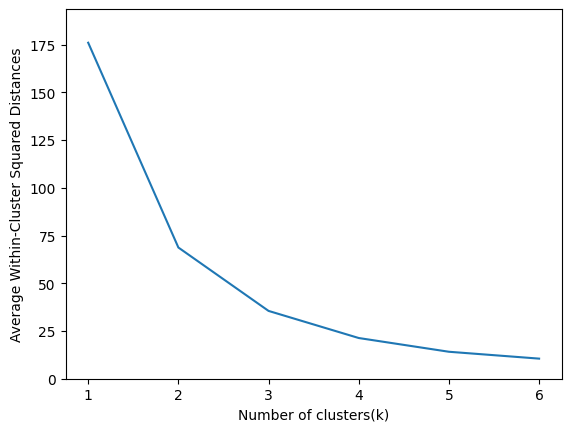

In [14]:
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(utilities_df_norm)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()